В этом ноутбуке пользовательские фото обрабатываются, чтобы получить аналогичные изображения из статьи [Kenshimov C. et al. Sign language dactyl recognition based on machine learning algorithms // Eastern-European Journal of Enterprise Technologies. 2021. Vol. 4. No. 2. P. 112.](https://www.researchgate.net/publication/354349413_Sign_language_dactyl_recognition_based_on_machine_learning_algorithms)


# Получение изображений по ключевым точкам рук

Это популярный метод предобработки в области распознавания жестов [[1]](https://www.researchgate.net/publication/371937989_Gesture_based_Sign_Language_Recognition_system_using_Mediapipe), [[2]](https://www.researchgate.net/publication/374146815_Sign_Language_Recognition_from_Video_using_Geometrical_and_Transfer_Learning_Techniques), [[3]](https://www.sciencedirect.com/science/article/pii/S2666307423000177). Конкретно в данном исследовании используется модуль mediapipe Hands для обнаружения и распознавания руки. Модель mediapipe выдает координаты ключевых точек рук, которое в дальнейшем исследователи используют для различных методов предобработки.

В данном ноутбуке с помощью модели mediapipe из таких пользовательских изображений:

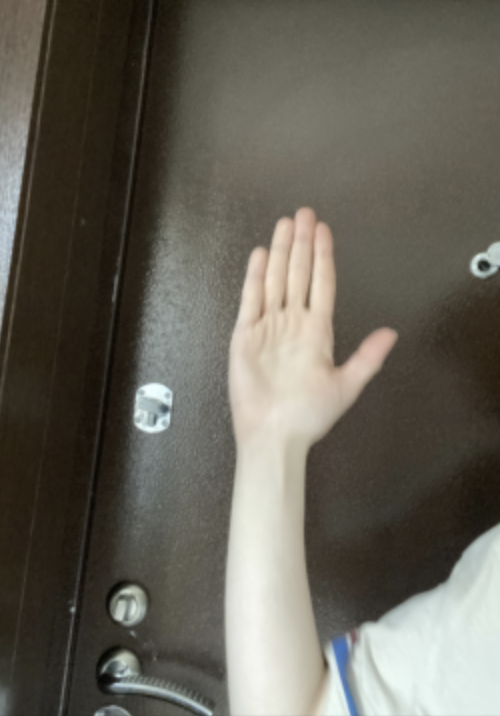


были получены следующие изображения:

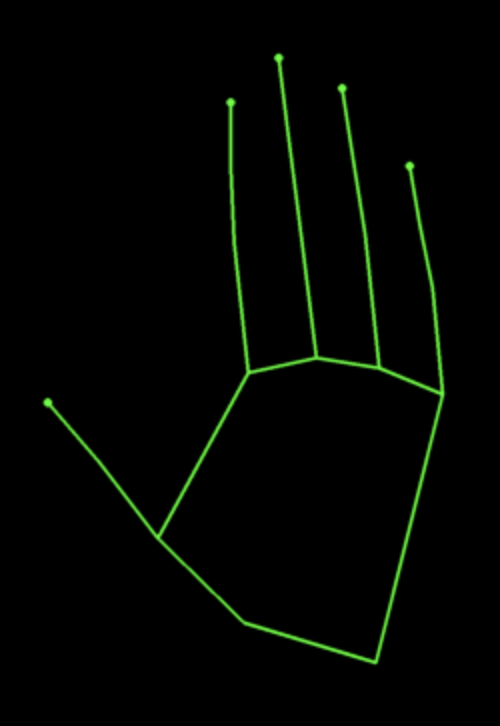

In [ ]:
# для начала установим саму библиотеку

!pip install mediapipe
!pip install cvzone

In [ ]:
import numpy as np
import pandas as pd
import glob
import os
import cv2 as cv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import keras
import csv
import mediapipe as mp
import copy
import tqdm.notebook


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Необходимые функции

In [ ]:
def calc_landmark_list(image, landmarks):
    """
    Calculate the pixel coordinates of landmarks from normalized coordinates.

    This function converts the landmarks' normalized coordinates (ranging from 0 to 1)
    into pixel coordinates based on the dimensions of the provided image.

    Parameters:
    image (numpy.ndarray): A numpy array representing the image. The array shape is expected to be
                           (height, width, channels), where `height` is the number of rows,
                           `width` is the number of columns, and `channels` is the number of color channels
                           (e.g., 3 for RGB images).
    landmarks (object): An object containing landmark data. It is expected to have a `landmark` attribute,
                        which is an iterable (e.g., list or array) of landmark points. Each landmark point
                        should have `x` and `y` attributes representing normalized coordinates.

    Returns:
    list: A list of lists containing pixel coordinates of the landmarks.
          Each inner list has two integers representing the x and y coordinates of a landmark point.
    """
    image_height, image_width = image.shape[:2]

    # Calculate the landmark points using list comprehension
    landmark_point = [
        [
            min(int(landmark.x * image_width), image_width - 1),
            min(int(landmark.y * image_height), image_height - 1)
        ]
        for landmark in landmarks.landmark
    ]

    return landmark_point


def draw_landmarks(image, landmark_point):
    """
    Draw landmarks and connections on the image.

    Parameters:
    image (numpy.ndarray): The image on which to draw.
    landmark_point (list): A list of lists containing pixel coordinates of the landmarks.
                           Each inner list has two integers representing the x and y coordinates of a landmark point.

    Returns:
    numpy.ndarray: The image with landmarks and connections drawn on it.
    """
    thickness = 3
    circles = 4
    color = (0, 255, 0)

    # Define connections between landmarks
    connections = [
        (2, 3), (3, 4),       # Thumb
        (5, 6), (6, 7), (7, 8), # Index finger
        (9, 10), (10, 11), (11, 12), # Middle finger
        (13, 14), (14, 15), (15, 16), # Ring finger
        (17, 18), (18, 19), (19, 20), # Little finger
        (0, 1), (1, 2), (2, 5), (5, 9), (9, 13), (13, 17), (17, 0) # Palm
    ]

    # Draw connections
    for start, end in connections:
        cv.line(image, tuple(landmark_point[start]), tuple(landmark_point[end]), color, thickness)

    # Key Points
    key_points_indices = [4, 8, 12, 16, 20]
    for index in key_points_indices:
        cv.circle(image, tuple(landmark_point[index]), circles, color, thickness)

    return image

In [ ]:
def extract_feature(input_image):
    """
    Extracts hand landmarks from an input image and returns an image with the hand cropped and the landmarks.

    Parameters:
    input_image (str): Path to the input image.

    Returns:
    tuple: A tuple containing:
        - result_image (numpy.ndarray): The cropped image with the hand.
        - landmark_list (list): A list of pixel coordinates for the hand landmarks.
    """
    mp_hands = mp.solutions.hands
    image = cv.imread(input_image)
    image_height, image_width = image.shape[:2]
    empty_array = np.zeros((image_height, image_width, 3), dtype=np.uint8)

    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.1) as hands:
        results = hands.process(cv.flip(cv.cvtColor(image, cv.COLOR_BGR2RGB), 1))
        if not results.multi_hand_landmarks:
            print(f"{input_image} Hand does not have landmarks")
            return empty_array, []

        hand_landmarks = results.multi_hand_landmarks[0]
        landmark_list = calc_landmark_list(empty_array, hand_landmarks)
        debug_image = draw_landmarks(empty_array, landmark_list)

        # Initialize bounding box coordinates
        width_min, width_max = 100000, 0
        height_min, height_max = 100000, 0
        indent_height, indent_width = 100, 100

        # Find the bounding box of the landmarks
        for x, y in landmark_list:
            width_min = min(width_min, x)
            width_max = max(width_max, x)
            height_min = min(height_min, y)
            height_max = max(height_max, y)

        # Adjust bounding box with indent
        width_min = max(0, width_min - indent_width)
        width_max = min(image_width, width_max + indent_width)
        height_min = max(0, height_min - indent_height)
        height_max = min(image_height, height_max + indent_height)

        result_image = empty_array[height_min:height_max, width_min:width_max]

    return result_image, landmark_list

Разделим данные на выборки. Будем обрабатывать каждую по отдельности

In [ ]:
DATA_PATH = "путь до пользовательских картинок"
RANDOM_STATE = 128

dactyl = ["А", "Б", "В", "Г", "Е",
          "Ж", "И", "К", "Л", "М",
          "Н", "О", "П", "Р", "С",
          "Т", "У", "Ф", "Х", "Ч",
          "Ш", "Ы", "Э", "Ю", "Я"]

list_path = []
list_labels = []
for label in dactyl:
    label_path = os.path.join(DATA_PATH, label + "/")
    for files in os.listdir(label_path):
      list_path.append(files)
      list_labels.append(label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata.head()

,image_path,label
0,1574433070_AgACAgIAAxkBAAIIWGXx4BQOOipO0hDOgCo...,А
1,655542129_AgACAgIAAxkBAAIFxWXkWvKtpUcM27HspPnH...,А
2,284383833_AgACAgIAAxkBAAIH5GXxpRW2C71SuyZr3ok3...,А
3,1388722399_AgACAgIAAxkBAAIHEWXp3yyttzgx0jRIZ9o...,А
4,881416533_AgACAgIAAxkBAAIJ5mXzIYrnZ8B9ItpfQztP...,А


In [ ]:
train_ratio = 0.90
test_ratio = 0.10


x_train, x_test, y_train, y_test = train_test_split(metadata.image_path,
                                                    metadata.label,
                                                    test_size= 1 - train_ratio,
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=metadata.label)

x_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
x_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [ ]:
for symbol in set(y_test):
  os.mkdir(os.path.join(DATA_PATH, "папка_для_новых_изображений_TRAIN", symbol))

for i in range(len(x_train)):
  empty_array, landmark_list = extract_feature(os.path.join(DATA_PATH, y_train[i], x_train[i]))
  if landmark_list == 0:
    print(f"image {os.path.join(DATA_PATH, y_train[i], x_train[i])} do not have lanmarks")
    pass
  else:
    cv.imwrite(os.path.join(DATA_PATH, "папка_для_новых_изображений_TRAIN", y_train[i], x_train[i]), cv.resize(empty_array, (128,128)))
    if i%100 == 0:
      print(f"Обработано {i} изображений")

print(f"Препроцессинг для выборки x_train ЗАКОНЧЕН")

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Обработано 0 изображений
Препроцессинг для выборки x_train ЗАКОНЧЕН


In [ ]:
#os.mkdir(os.path.join(DATA_PATH, "папка_для_новых_изображений"))

for symbol in set(y_test):
  os.mkdir(os.path.join(DATA_PATH, "папка_для_новых_изображений_TEST", symbol))

for i in range(len(x_test[:5])):
  empty_array, landmark_list = extract_feature(os.path.join(DATA_PATH, y_test[i], x_test[i]))
  if landmark_list == 0:
    continue
  else:
    cv.imwrite(os.path.join(DATA_PATH, "папка_для_новых_изображений_TEST", y_test[i], x_test[i]), cv.resize(empty_array, (128,128)))
    if i%10 == 0:
      print(f"Обработано {i} изображений")

print(f"Препроцессинг для выборки x_test ЗАКОНЧЕН")

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Обработано 0 изображений
Препроцессинг для выборки x_test ЗАКОНЧЕН
